<a href="https://colab.research.google.com/github/abidur0177/TIme-Series-Prediction/blob/main/Predict_time_seires_with_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this project, I will be predicting the same old time series, but instead of using a single layer architecture, I will be using a deep neural network.

### Import the necessary libraries

In [49]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

### Create the utility functions

In [50]:
# Define the series plotting function
def plot_series(time, series, format="-", start=0, end=None):

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# Define the trend line
def trend(time, slope=0):

    # Compute the linear series given the slope
    series = slope * time

    return series

# Define a random seasonal pattern
def seasonal_pattern(season_time):

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.3,
                    np.sin(season_time * 1.68 * np.pi),
                    1.7 / np.exp(2.34 * season_time))

    return data_pattern

# Define the seasonality
def seasonality(time, period, amplitude=2.5, phase=0):

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

# Define the noise
def noise(time, noise_level=1, seed=None):

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

### Generate synthetic series

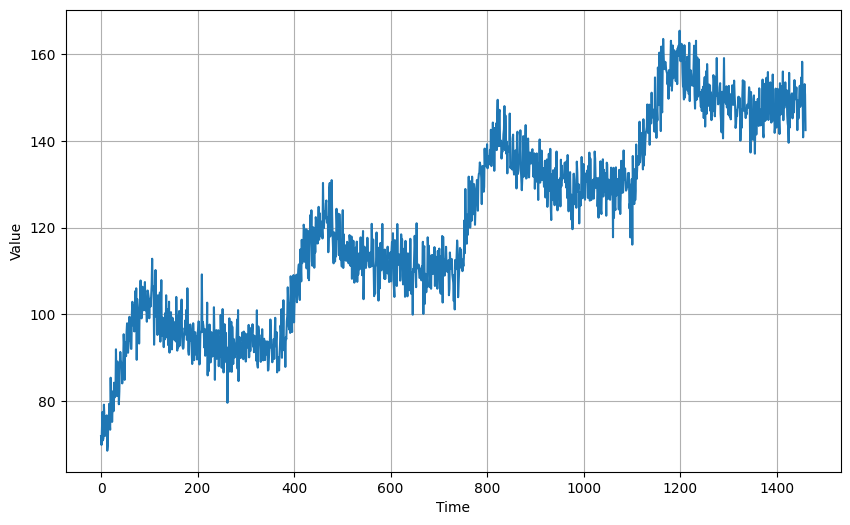

In [51]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 70
amplitude = 30
slope = 0.05
noise_level = 4

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

### Splitting the dataset into training and validation set

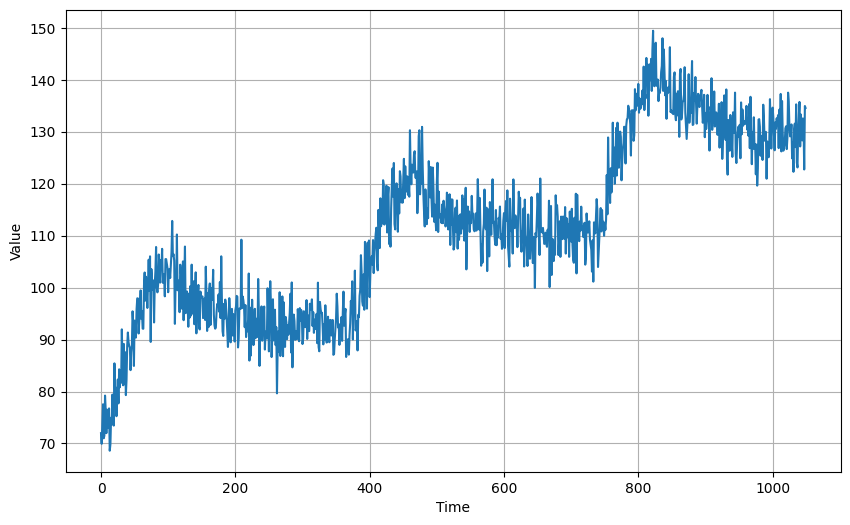

In [52]:
# Define the split time
split_time = 1050

# Get the train set
time_train = time[:split_time]
series_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
series_valid = series[split_time:]


# Plot the train set
plot_series(time_train, series_train)

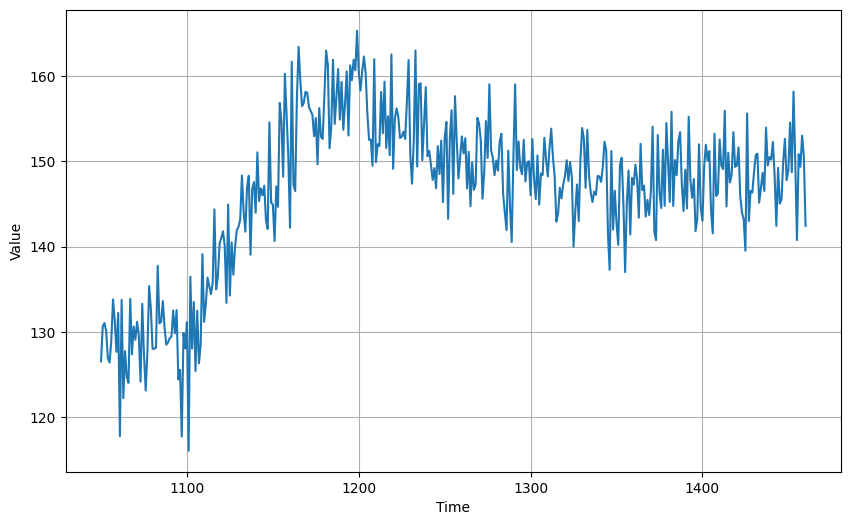

In [53]:
# Plot the validation set
plot_series(time_valid, series_valid)

### Generate features and labels

In [54]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1500


# Generate a windowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


# Generate the dataset windows
dataset = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)


# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


### Build and compile the model

In [55]:
# Create the model
model = keras.Sequential([
    keras.layers.Dense(10, input_shape=[window_size], activation=tf.nn.relu),
    keras.layers.Dense(12, activation=tf.nn.relu),
    keras.layers.Dense(1)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                210       
                                                                 
 dense_13 (Dense)            (None, 12)                132       
                                                                 
 dense_14 (Dense)            (None, 1)                 13        
                                                                 
Total params: 355 (1.39 KB)
Trainable params: 355 (1.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
# Define the callback function for tuning the learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-10 * 10**(epoch / 100))

In [57]:
# Compile the model
model.compile(loss='mse', optimizer=keras.optimizers.SGD(momentum=0.9))

### Train the model

In [58]:
history = model.fit(dataset, epochs=500, callbacks=[lr_schedule])

Epoch 1/500
33/33 [==============================] - 1s 2ms/step - loss: 18332.3672 - lr: 1.0000e-10
Epoch 2/500
33/33 [==============================] - 0s 1ms/step - loss: 18265.1270 - lr: 1.0233e-10
Epoch 3/500
33/33 [==============================] - 0s 2ms/step - loss: 18191.3477 - lr: 1.0471e-10
Epoch 4/500
33/33 [==============================] - 0s 2ms/step - loss: 18116.5469 - lr: 1.0715e-10
Epoch 5/500
33/33 [==============================] - 0s 3ms/step - loss: 18041.4121 - lr: 1.0965e-10
Epoch 6/500
33/33 [==============================] - 0s 2ms/step - loss: 17965.6875 - lr: 1.1220e-10
Epoch 7/500
33/33 [==============================] - 0s 3ms/step - loss: 17888.9863 - lr: 1.1482e-10
Epoch 8/500
33/33 [==============================] - 0s 2ms/step - loss: 17811.9297 - lr: 1.1749e-10
Epoch 9/500
33/33 [==============================] - 0s 2ms/step - loss: 17733.7539 - lr: 1.2023e-10
Epoch 10/500
33/33 [==============================] - 0s 1ms/step - loss: 17655.2227 - lr: 

(1e-09, 1e-05, 0.0, 400.0)

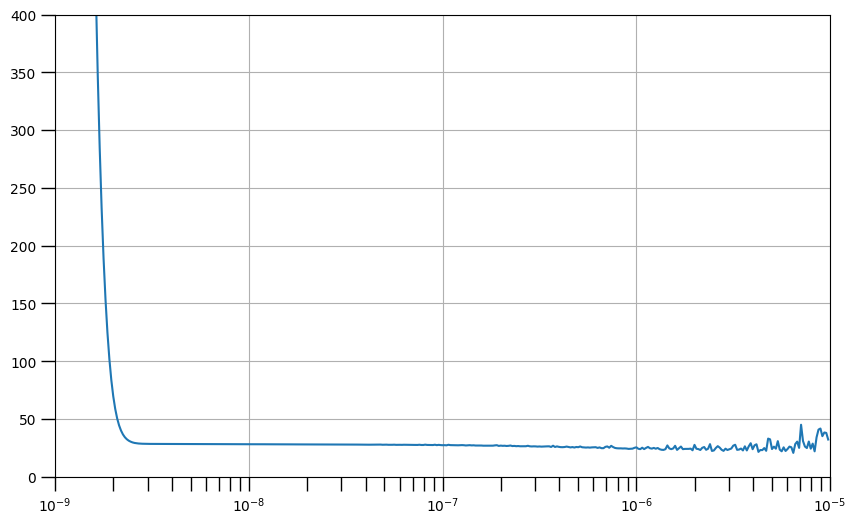

In [64]:
# Define the learning rate array
lrs = 1e-10 * (10 ** (np.arange(500) / 100))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-9, 1e-5, 0, 400])

### Get the appropriate learning rate

In [72]:
# Get the index of the minimum loss value
loss_min = np.argmin(history.history['loss'])

# Get the learning rate from that position
lr = lrs[loss_min]
lr

6.45654229034655e-06

In [73]:
# Set the learning rate for compiling the model
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9))

In [76]:
# Train the model for 100 epochs
history = model.fit(dataset, epochs=100)

Epoch 1/100
33/33 [==============================] - 0s 3ms/step - loss: 25.2343
Epoch 2/100
33/33 [==============================] - 0s 5ms/step - loss: 22.8418
Epoch 3/100
33/33 [==============================] - 0s 1ms/step - loss: 23.1545
Epoch 4/100
33/33 [==============================] - 0s 2ms/step - loss: 22.8549
Epoch 5/100
33/33 [==============================] - 0s 2ms/step - loss: 26.0038
Epoch 6/100
33/33 [==============================] - 0s 1ms/step - loss: 24.2348
Epoch 7/100
33/33 [==============================] - 0s 1ms/step - loss: 30.4706
Epoch 8/100
33/33 [==============================] - 0s 1ms/step - loss: 21.0703
Epoch 9/100
33/33 [==============================] - 0s 1ms/step - loss: 25.9585
Epoch 10/100
33/33 [==============================] - 0s 1ms/step - loss: 23.4366
Epoch 11/100
33/33 [==============================] - 0s 1ms/step - loss: 20.5823
Epoch 12/100
33/33 [==============================] - 0s 2ms/step - loss: 26.3856
Epoch 13/100
33/33 [=====

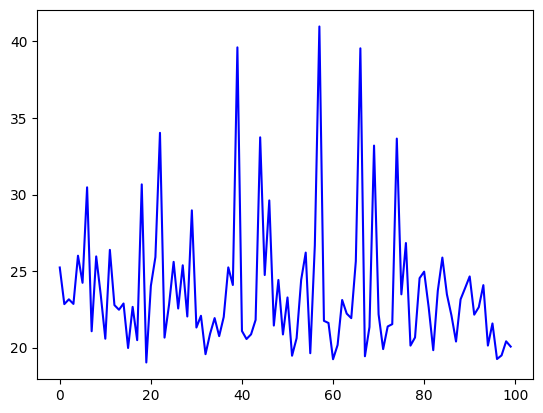

In [77]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

1/1 [==============================] - 0s 89ms/step


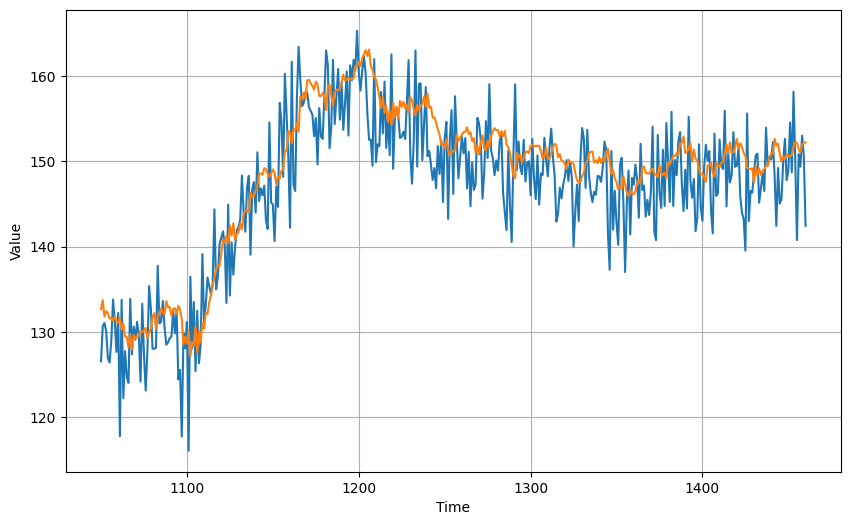

In [78]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (series_valid, results))

In [79]:
# Get the error metrices
print(tf.keras.metrics.mean_squared_error(series_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(series_valid, results).numpy())

22.936207
3.851096
